## Homework 1 solution

Let's use the following convention for numbering legs:
```
 1--A--3
    |
    2
```

In [124]:
using TensorOperations
using LinearMaps

In [125]:
"""
    rand_UMPS(d, D; keep_it_real=true)

Return a random three-valent tensor A, that defines a uniform MPS (UMPS).
The bond dimension of the physical leg should be d, and the bond dimension
of the two "virtual" legs (the horizontal ones) should be D.
keep_it_real is keyword argument, for whether the matrix should be real or
complex.

This means you can call
`rand_UMPS(2, 9)`
or
`rand_UMPS(2, 9; keep_it_real=true)`
and they both give a you real A, but you can also call
`rand_UMPS(2, 9; keep_it_real=false)`
to get a complex A.
"""
function rand_UMPS(d, D; keep_it_real=true)
    shp = (D, d, D)
    if keep_it_real
        A = randn(shp)
    else
        A_real = randn(shp)
        A_imag = randn(shp)
        A = complex.(A_real, A_imag) / sqrt(2)
    end
    return A
end

rand_UMPS

In [126]:
"""
    tm(A)

Return the transfer matrix of A:
 --A---
   |  
 --A*--
"""
function tm(A)
    @tensor T[i1,i2,j1,j2] := A[i1,p,j1]*conj(A)[i2,p,j2]
end

tm

In [127]:
function eig_and_trunc(T, nev; by=identity, rev=false)
    S, U = eig(T)
    perm = sortperm(S; by=by, rev=rev)
    S = S[perm]
    U = U[:, perm]
    S = S[1:nev]
    U = U[:, 1:nev]
    return S, U
end

"""
    tm_eigs(A, dirn, nev)

Return some of the eigenvalues and vectors of the transfer matrix of A.
dirn should be "L", "R" or "BOTH", and determines which eigenvectors to return.
nev is the number of eigenpairs to return (starting with the eigenvalues with
largest magnitude).
"""
function tm_eigs_dense(A, dirn, nev)
    T = tm(A)
    D = size(T, 1)
    T = reshape(T, (D^2, D^2))
    nev = min(nev, D^2)
    
    result = ()
    if dirn == "R" || dirn == "BOTH"
        SR, UR = eig_and_trunc(T, nev; by=abs, rev=true)
        UR = [reshape(UR[:,i], (D, D)) for i in 1:nev]
        result = tuple(result..., SR, UR)
    end
    if dirn == "L" || dirn == "BOTH"
        SL, UL = eig_and_trunc(T', nev; by=abs, rev=true)
        UL = [reshape(UL[:,i], (D, D)) for i in 1:nev]
        result = tuple(result..., SL, UL)
    end
    return result
end

tm_eigs_dense

In [128]:
"""
    tm_l(A, x)

Return y, where
/------   /------A--
|       = |      |  
\- y* -   \- x* -A*-
"""
function tm_l(A, x)
    @tensor y[i, j] := (x[a, b] * A[b, p, j]) * conj(A[a, p, i])
    return y
end


"""
    tm_r(A, x)

Return y, where
-- y -\   --A-- x -\
      | =   |      |
------/   --A*-----/
"""
function tm_r(A, x)
    @tensor y[i, j] := A[i, p, a] * (conj(A[j, p, b]) * x[a, b])
    return y
end


tm_r

In [129]:
function tm_eigs_sparse(A, dirn, nev)
    if dirn == "BOTH"
        SR, UR = tm_eigs_sparse(A, "R", nev)
        SL, UL = tm_eigs_sparse(A, "L", nev)
        return SR, UR, SL, UL
    else
        D = size(A, 1)
        x = zeros(eltype(A), (D, D))
        if dirn == "L"
            f = v -> vec(tm_l(A, copy!(x, v)))
        else
            f = v -> vec(tm_r(A, copy!(x, v)))
        end

        fmap = LinearMap{eltype(A)}(f, D^2)
        S, U, nconv, niter, nmult, resid = eigs(fmap, nev=nev, which=:LM, ritzvec=true)
        U = [reshape(U[:,i], (D, D)) for i in 1:size(U, 2)]

        return S, U
    end
end

tm_eigs_sparse (generic function with 1 method)

In [130]:
function tm_eigs(A, dirn, nev; max_dense_D=10)
    D = size(A, 1)
    if D <= max_dense_D || nev >= D^2
        return tm_eigs_dense(A, dirn, nev)
    else
        return tm_eigs_sparse(A, dirn, nev)
    end
end

tm_eigs (generic function with 1 method)

In [131]:
"""
    normalize!(A)

Normalize the UMPS defined by A, and return the dominant left and right
eigenvectors l and r of its transfer matrix, normalized so that l'*r = 1.
"""
function normalize!(A)
    SR, UR, SL, UL = tm_eigs(A, "BOTH", 1)
    S1 = SR[1]
    A ./= sqrt(S1)
    
    l = UL[1]
    r = UR[1]  
    #We need this to be 1
    n = vec(l)'*vec(r)
    abs_n = abs(n)
    phase_n = abs_n/n
    sfac = 1.0/sqrt(abs_n)
    l .*= sfac/phase_n
    r .*= sfac
    return l, r
end

normalize!

## Homework 2 solution

In [132]:
"""
    tm_l_op(A, O, x)

Return y, where
/------   /------A--
|         |      |  
|       = |      O  
|         |      |  
\- y* -   \- x* -A*-
"""
function tm_l_op(A, O, x)
    @tensor y[i, j] := (x[a, b] * A[b, p2, j]) * (conj(A[a, p1, i]) * conj(O[p1, p2]))
    return y
end


"""
    tm_r_op(A, O, x)

Return y, where
-- y -\   --A-- x -\
      |     |      |
      | =   O      |
      |     |      |
------/   --A*-----/
"""
function tm_r_op(A, O, x)
    @tensor y[i, j] := (A[i, p1, a] * O[p1, p2]) * (conj(A[j, p2, b]) * x[a, b])
    return y
end


tm_r_op

In [134]:
"""
    expect_local(A, O, l, r)

Return the expectation value of the one-site operator O for the UMPS state
defined by the tensor A.
"""
function expect_local(A, O, l, r)
    l = tm_l_op(A, O, l)
    expectation = vec(l)'*vec(r)
    return expectation
end

expect_local

In [136]:
"""
    correlator_twopoint(A, O1, O2, m, l, r)

Return the (connected) two-point correlator of operators O1 and O2 for the
state UMPS(A), when O1 and O2 are i sites apart, where i ranges from 1 to m. In
other words, return <O1_0 O2_i> - <O1> <O2>, for all i = 1,...,m, where the
expectation values are with respect to the state |UMPS(A)>.
"""
function correlator_twopoint(A, O1, O2, m, l, r)
    local_O1 = expect_local(A, O1)
    local_O2 = expect_local(A, O2)
    disconnected = local_O1 * local_O2
    
    l = tm_l_op(A, O1, l)
    r = tm_r_op(A, O2, r)
    
    result = zeros(eltype(A), m)
    result[1] = vec(l)'*vec(r) - disconnected
    for i in 1:m
        r = tm_r(A, r)
        result[i] = vec(l)'*vec(r) - disconnected
    end
    return result
end

correlator_twopoint

In [137]:
"""
    correlation_length(A)

Return the correlation length ξ of the UMPS defined by A. ξ = - 1/ln(|lambda[2]|),
where lambda[2] is the eigenvalue of the MPS transfer matrix with second largest
magnitude. (We assume here that UMPS(A) is normalized.)
"""
function correlation_length(A)
    S, U = tm_eigs(A, "L", 2)
    s2 = S[2]
    ξ = -1/log(abs(s2))
    return ξ
end

correlation_length

In [155]:
d = 2
D = 100
A = rand_UMPS(d, D; keep_it_real=false)
l, r = normalize!(A)

O1 = randn(d, d)
O2 = randn(d, d)
O1 = (O1 + O1')/2
O2 = (O2 + O2')/2
expect_O1 = expect_local(A, O1, l, r)
expect_O2 = expect_local(A, O2, l, r)
@show expect_O1
@show expect_O2

m = 80
@time corrs = correlator_twopoint(A, O1, O2, m, l, r);

expect_O1 = 1.1913746835455319 + 3.3306690738754696e-16im
expect_O2 = -0.5921670305685184 - 1.1102230246251565e-16im
  1.630759 seconds (85.68 k allocations: 794.959 MiB, 2.95% gc time)


In [156]:
ξ = correlation_length(A)

2.9701283670750045

In [143]:
#Pkg.add("PyPlot")
using PyPlot

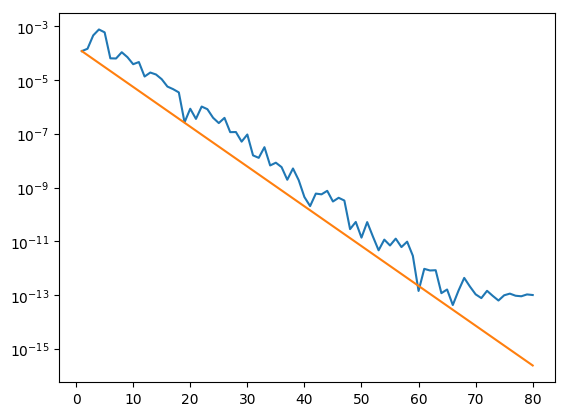

2-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fc15f2f06d0>
 PyObject <matplotlib.lines.Line2D object at 0x7fc15f2708d0>

In [157]:
C = abs(corrs[1])
semilogy(1:m, abs.(corrs), [1,m], [C, C*exp(-m/ξ)])

# But I don't care about random MPSes!

Now that you know how to compute correlation functions for MPS states, we should start thinking about how do we get a useful MPS state in the first place. So far all our states have been defined by tensors $A$ with random elements.

Some fun little analytical examples exist, such as how to represent GHZ or W states as MPSes. You can google them up. The real question is though, given an arbitrary local Hamiltonian, can we find an MPS for the ground state. We know that for gapped Hamiltonians (i.e. most Hamiltonians) correlations in the ground state decay exponentially and entanglement is limited (area law), so there's hope that the answer would be "yes we can".

You can think about this problem in a few different ways. One is to ask, what's the lowest energy state we can find on the manifold of MPS states. The question is then a matter of optimizing for minimal expectation value $\langle \psi | H | \psi \rangle$ under the constraint that the state $|\psi \rangle$ is an MPS. Another way to approach this would be writing down some expression for the exact ground state (an expression we obviously can't just go an evaluate, otherwise there would be no problem), and then try to massage that expression into an MPS.

Various algorithms for implementing these different approaches in different situations (finite-size, infinite-size, translation invariant or not, what kind of boundary conditions) exist. Some examples are the Density Matrix Renormalization Group (DMRG), Time-Dependent Variational Principle (TDVP) and Time-Evolving Block Decimation (TEBD). We'll implement an infinite-lattice version of TEBD. Why TEBD? Because it's simple, and because it you can also use it to do time-evolution of MPS states. (I maintain that the choice to pick TEBD is independent of the fact that Guifre invented it.)

Implementing iTEBD will be the rest of this minicourse. However, we'll only really get to that next time. First, we need to talk a bit about gauge freedom in MPS and how to fix this freedom, since TEBD will be making use of a specific gauge.

## Gauge freedom and canonical forms
In any tensor network, we can always take any contracted leg, and insert on that leg a pair of invertible matrices $g g^{-1} = \mathbb{1}$. This doesn't affect the value the network contracts to in anyway: we've just changed the basis in which we perform one of the sums (traces).

This means that an MPS representation of a state is not unique. We can insert any $g g^{-1}$ on any of the virtual legs of the MPS, and the state stays the same. Obviously, we would like to stay within the framework of translation invariant MPSes, so we allow only for gauge transformations (as these changes of basis are called) of the form
```
--A-- -> --gi--A--g--
  |            |
```
where by `gi` I mean the inverse of $g$.

Since we have some freedom in picking $A$, we should probably try to make use of it somehow, while fixing the freedom. How? Well, we could try to impose some nice properties on $A$, if such properties can be achieved by a gauge transformation. And it turns out there's a really useful property that we can impose, which goes as follows.

First, we have to complicate our setup slightly. Previously our how MPS was defined by $A$. Now, let's think of an MPS that is instead written as
```
... --λ--Γ--λ--Γ--λ--Γ--λ-- ...
         |     |     |
```
Here $\Gamma$ is some tensor, and $\lambda$ is a diagonal matrix, with real, non-negative elements. Obviously we could just absorb $\lambda$ into $\Gamma$ and a get single tensor $A$. The point is, by using the gauge freedom, we can choose $\Gamma$ and $\lambda$ in such a way, that *$\lambda$ always has on its diagonal the Schmidt coefficients of partitioning the state into two parts at $\lambda$*. What are Schmidt coefficients? https://en.wikipedia.org/wiki/Schmidt_decomposition

Another way of stating the same condition is to say that the left dominant eigenvector of
```
--λ--Γ--
     |
--λ--Γ--
```
and the right dominant eigenvector of
```
--Γ--λ--
  |
--Γ--λ--
```
are both the identity matrix.

Choosing our gauge so that this property holds turns out to be quite handy. You'll see next time how it's used in the TEBD algorithm, but you can probably already imagine that it's kinda nice that on each virtual legs you have these Schmidt coefficients $\lambda$, that immediately tell you everything you would want to know about the entanglement between the two sides of the state separated by this leg. The bond dimension is also obviously the Schmidt rank, which gives us a very concrete, physical characterization of what high bond dimension and low bond dimension mean, and in what sense are MPSes "low entanglement" states.

So, given $A$, how do we find a gauge transformation such that the above property holds? I'm getting tired of typing, so just go read Section II of https://arxiv.org/pdf/0711.3960.pdf, that will explain it all. Then, it's time for your homework.

## Homework 3
#### -1)
Make sure that, for the expectation values and correlation functions that you implemented last time,<br>
a) Your expectation values for Hermitian operators are real.<br>
b) Your correlation functions decay like they should (make a plot).<br>
c) You can generate two-point correlators with $D=100$ for distances $1, \dots, 100$ or so in a few seconds.<br>
Feel free to make use of my code above, as long as you understand what's going on. You don't necessarily need to send this part of the homework to me once your done, just see yourself that it works.

#### 0)
Read Section II of https://arxiv.org/pdf/0711.3960.pdf. Note that there they start from some $\Gamma$ and $\lambda$, that are not the canonical form, and try to turn them into $\Gamma'$ and $\lambda'$ that would be in the canonical form. We, on the other hand, start from just $A$. You can easily translate to their language by setting their $\Gamma$ to your $A$, and their $\lambda$ to just the identity matrix.

#### 1)
As explained in above reference, the form of MPS transfer matrix $T$, i.e. the symmetry it has because of how it consists of $A$ and $A^\ast$, guarantees that the dominant eigenvectors $l$ and $r$ are Hermitian and positive semi-definite. However, as we discussed in the last meeting, when we numerically ask for the eigenvectors, they come with an arbitrary phase. Last time we modified `normalize!` so that it partially fixes this phase (and also the norm of $l$ and $r$), imposing `vec(l)'*vec(r) == 1`. Your first job is to further modify `normalize!` so that it fully fixes the phases, so that the `l` and `r` it returns are Hermitian and positive semi-definite, in addition to having the property that `vec(l)'*vec(r) == 1`.

How do you do that? Well, you should definitely start by getting the `normalize!` function from above, and only make small modifications to that. Since we know that $r$ is actually $a \cdot \tilde{r}$, where $\tilde{r}$ is Hermitian and pos. semi-def. and $a$ is a scalar, we can just take the trace $\mathrm{Tr} r = a \mathrm{Tr} \tilde{r}$, and we know that $\mathrm{Tr} \tilde{r}$ is something real and positive. Any part of $\mathrm{Tr} r$ that is not real and positive, is $a$, and you divide $r$ by $a$ to get $\tilde{r}$. And similarly for $l$.

In [123]:
"""
    normalize!(A)

Normalize the UMPS defined by A, and return the dominant left and right
eigenvectors l and r of its transfer matrix, normalized so that they are
both Hermitian and positive semi-definite (when thought of as matrices),
and l'*r = 1.
"""
function normalize!(A)
    SR, UR, SL, UL = tm_eigs(A, "BOTH", 1)
    S1 = SR[1]
    A ./= sqrt(S1)
    
    l = UL[1]
    r = UR[1]  
    # ???
    return l, r
end

normalize!

#### 2)
Now that we can trust our $l$ and $r$ to be Hermitian and $\geq 0$, we can go ahead and implement a function that takes in $A$, $l$ and $r$, and outputs $\Gamma$ and $\lambda$, that define the same MPS, but now in canonical form.

In [115]:
"""
    canonical_form(A, l, r)

Return a three-valent tensor Γ and a vector λ, that define the canonical
of the UMPS defined by A. l and r should be the normalized dominant
left and right eigenvectors of A.
"""
function canonical_form(A, l, r)
    # ???
end

canonical_form (generic function with 1 method)

#### 3)
Prove to yourself that<br>
a)<br>
the way you've chosen to transform the MPS, going from $A$ to $(\Gamma, \lambda)$, is actually a gauge transformation. In other words, prove that they both define the same state.

b)<br>
that the MPS defined by your new $\Gamma$ and $\lambda$ is actually in canonical form, i.e., that the left dominant eigenvector of
```
--λ--Γ--
     |
--λ--Γ--
```
and the right dominant eigenvector of
```
--Γ--λ--
  |
--Γ--λ--
```
are both the identity matrix. Do this both numerically and analytically.